<a href="https://colab.research.google.com/github/soffiyahabass1/Machine-learning-Projects/blob/main/CT_Scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Prepocessing

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
input_dir = "/content/drive/MyDrive/pcos/CT-Scan images/CT-Scan images/CT-Scan Images"
output_base = 'processed_dataset'
train_dir = os.path.join(output_base, 'train')
test_dir = os.path.join(output_base, 'test')

test_size = 0.2

# Create output directories
for split_dir in [train_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Process each class
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get all image paths in the class folder
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)
              if img.lower().endswith(('.png', '.jpg', '.jpeg'))]


    if not images:
        print(f"Warning: No images found in {class_path}, skipping...")
        continue


    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)


    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(train_dir, class_name, os.path.basename(img_path)))

    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(test_dir, class_name, os.path.basename(img_path)))

print("Dataset successfully split into training and testing sets.")

Dataset successfully split into training and testing sets.


In [ ]:
train_dir = os.path.join(output_base, 'train')
test_dir = os.path.join(output_base, 'test')


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 200)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform = transform,
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b12c2ee0590>,
 ['Cancerous raw images-jpg', 'Non-Cancerous raw images - jpg'])

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 128, 200]), torch.Size([32]))

# Model

In [ ]:


import torch
import torch.nn as nn
x, _ = next(iter(train_dataloader))
num_input = x.shape[1]
width = x.shape[2]
length = x.shape[3]
window = 200


num_class = 2
c1 = 8
c2 = 24
c3 = c2
K = round((length - 50) / 10)
kernel_1 = (K, round(window / 2))
kernel_2 = (width, K)
kernel_3 = (1, 1)
kp_1 = (1, 4)
kp_2 = (1, 8)
drop_rate = 0.1
ks0 = int(round((kernel_1[0] - 1) / 2))
ks1 = int(round((kernel_1[1] - 1) / 2))
kernelpad = (ks0, ks1 - 1)

# Model
class custum_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.af = nn.ELU()
        self.drop = nn.Dropout2d(drop_rate)
        self.conv1 = nn.Conv2d(num_input, c1, kernel_1, padding=kernelpad)
        self.batch_1 = nn.BatchNorm2d(c1)
        self.conv2 = nn.Conv2d(c1, c2, kernel_2, groups=c1)
        self.batch_2 = nn.BatchNorm2d(c2)
        self.pool_1 = nn.AvgPool2d(kp_1)
        self.conv3 = nn.Conv2d(c2, c3, kernel_3)
        self.batch_3 = nn.BatchNorm2d(c3)
        self.pool_2 = nn.AvgPool2d(kp_2)
        self.fc1 = nn.Flatten()
        self._fc2 = None
        self.fc3 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.batch_1(self.conv1(x))
        x = self.batch_2(self.conv2(x))
        x = self.af(x)
        x = self.drop(self.pool_1(x))
        x = self.batch_3(self.conv3(x))
        x = self.af(x)
        x = self.drop(self.pool_2(x))
        x = self.fc1(x)

        if self._fc2 is None:
            self.fc2 = nn.Linear(x.shape[1], num_class).to(x.device)
            self._fc2 = nn.Linear(x.shape[1], num_class).to(x.device)
        x = self._fc2(x)
        x = self.fc3(x)
        return x

model = custum_model().to(device)
print(model)


custum_model(
  (af): ELU(alpha=1.0)
  (drop): Dropout2d(p=0.1, inplace=False)
  (conv1): Conv2d(1, 8, kernel_size=(15, 100), stride=(1, 1), padding=(7, 49))
  (batch_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 24, kernel_size=(128, 15), stride=(1, 1), groups=8)
  (batch_2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (conv3): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (batch_3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (fc1): Flatten(start_dim=1, end_dim=-1)
  (fc3): Softmax(dim=1)
)


In [ ]:
pip install scikit-learn


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py


--2025-05-14 09:47:53--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2025-05-14 09:47:54 (78.7 MB/s) - ‘helper_functions.py’ saved [10160/10160]



In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

Model Training

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
!pip install tqdm

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
import os
from PIL import Image
from torchvision import transforms as T
from torchvision.utils import make_grid

Model Training and Evaluation

train: 0.931, test: 0.9324


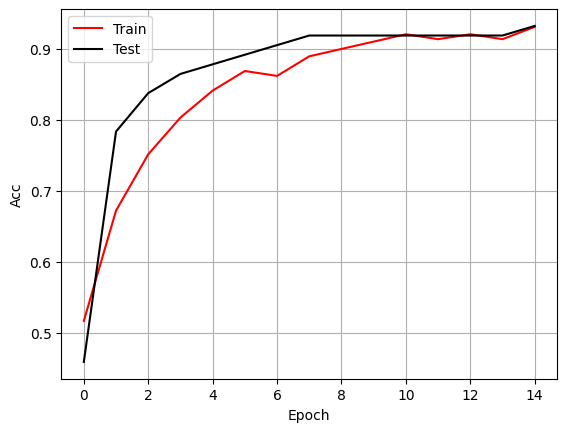

In [ ]:
eta= 0.00001
loss_fn= nn.CrossEntropyLoss().to(device)
optimizer= optim.NAdam(model.parameters(), lr= eta)


class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes= num_class).to(device)
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()
        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
    return model, loss_train.avg, acc_train.compute().item()

def evaluate(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes= num_class).to(device)
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss_valid.update(loss.item())
            acc_valid(outputs, targets.int())
    return loss_valid.avg, acc_valid.compute()

num_epochs = 15
loss_train_hist = []
loss_valid_hist = []
loss_test_hist = []
acc_train_hist = []
acc_valid_hist = []
acc_test_hist = []

for epoch in range(num_epochs):
    model, loss_train, acc_train= train_one_epoch(model, train_dataloader, loss_fn, optimizer)
    #loss_valid, acc_valid= evaluate(model, valid_loader, loss_fn)
    loss_test, acc_test= evaluate(model, test_dataloader, loss_fn)
    loss_train_hist.append(loss_train)
    ##loss_valid_hist.append(loss_valid)
    loss_test_hist.append(loss_test)
    acc_train_hist.append(acc_train)
    #acc_valid_hist.append(acc_valid.cpu())
    acc_test_hist.append(acc_test.cpu())

print(f'train: {acc_train:.4}, test: {acc_test:.4}')
plt.plot(acc_train_hist, 'r-', label='Train')
#plt.plot(acc_valid_hist, 'b-', label='Validation')
plt.plot(acc_test_hist, 'k-', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [38]:
import matplotlib.pyplot as plt

def predict_and_plot(model, sample_tensor, class_names, device):
    model.eval()
    with torch.inference_mode():
        # Ensure input has batch dimension and is on device
        sample = sample_tensor.unsqueeze(0).to(device)

        # Forward pass
        output = model(sample)
        pred_prob = torch.softmax(output, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1).item()

        # Plot the sample (if plottable)
        sample_np = sample_tensor.cpu().numpy()

        # If it's a single-channel image (C=1), squeeze it to plot
        if sample_np.shape[0] == 1:
            img = sample_np.squeeze()
            plt.imshow(img, cmap='gray')
        else:
            # If multiple channels, take first channel or permute for RGB if 3-channel
            img = sample_np[0]  # or use: np.transpose(sample_np, (1,2,0)) for RGB
            plt.imshow(img, cmap='gray')

        plt.title(f"Predicted: {class_names[pred_label]}")
        plt.axis("off")
        plt.show()

        return class_names[pred_label]


In [ ]:
from PIL import Image
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for image_path in data:
            # Load image
            image = Image.open(image_path).convert("RGB")

            # Transform image
            image_tensor = transform(image).unsqueeze(0).to(device)

            # Predict
            pred_logit = model(image_tensor)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


In [ ]:
def predict_and_plot_debug(model, sample, class_names, device):
    model.eval()
    with torch.inference_mode():

        sample = sample.unsqueeze(0).to(device)

        # Forward pass
        logits = model(sample)


        probs = torch.softmax(logits, dim=1)

        # Get predicted class
        pred_class = torch.argmax(probs, dim=1).item()

        # Print detailed info
        print("Logits:", logits.cpu().numpy())
        print("Probabilities:", probs.cpu().numpy())
        print("Predicted class index:", pred_class)
        print("Predicted class label:", class_names[pred_class])

    # Plot the image
    plt.imshow(sample.squeeze().cpu().permute(1, 2, 0), cmap='gray')
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()


In [40]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

transform = transforms.Compose([
    transforms.Resize((128, 200)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


def predict_and_plot_debug(model, image_path: str, class_names, device):
    """
    Loads an image from a path, performs prediction, and shows the image
    along with debug information.
    """
    model.eval()
    with torch.inference_mode():

        try:

            image = Image.open(image_path).convert("L")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_path}")
            return None
        except Exception as e:
            print(f"Error loading or processing image {image_path}: {e}")
            return None


        sample_tensor = transform(image)
        sample = sample_tensor.unsqueeze(0).to(device)

        # Forward pass
        logits = model(sample)
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

        # Print detailed info
        print("Logits:", logits.cpu().numpy())
        print("Probabilities:", probs.cpu().numpy())
        print("Predicted class index:", pred_class)
        print("Predicted class label:", class_names[pred_class])

    # Plot the image

    img_to_plot = sample_tensor.squeeze().cpu().numpy()
    plt.imshow(img_to_plot, cmap='gray')
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()




Logits: [[0.85471916 0.14528078]]
Probabilities: [[0.67027706 0.32972294]]
Predicted class index: 0
Predicted class label: Cancereous


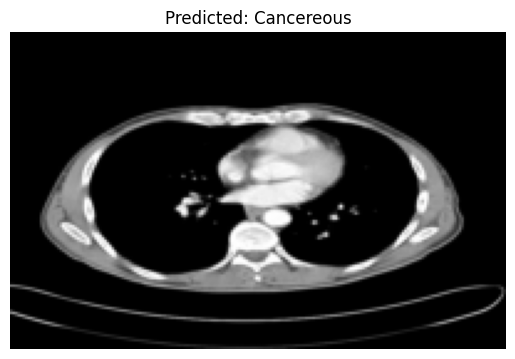

Logits: [[0.94306433 0.05693573]]
Probabilities: [[0.7080906 0.2919094]]
Predicted class index: 0
Predicted class label: Cancereous


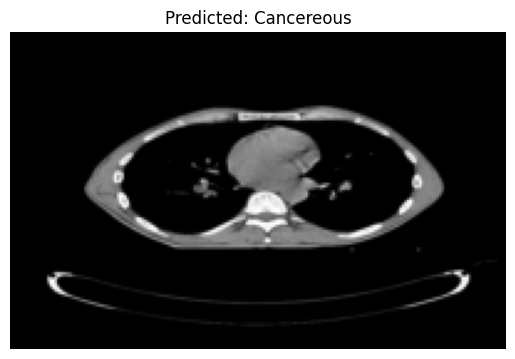

In [41]:
predict_and_plot_debug(model, test_imgs[0], class_names, device)
predict_and_plot_debug(model, test_imgs[1], class_names, device)

Evaluation Metrics


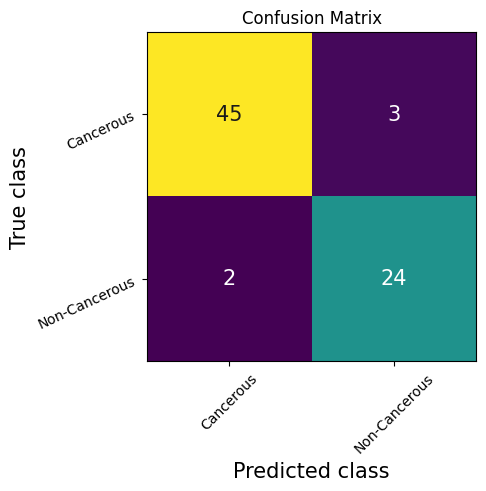

In [ ]:
from torchmetrics.classification import ConfusionMatrix
from torchmetrics.utilities.plot import plot_confusion_matrix
import matplotlib.pyplot as plt

# Define the confusion matrix metric
confmat = ConfusionMatrix(task="multiclass", num_classes=num_class).to(device)
model.eval()
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        confmat.update(preds, targets.int())

# Compute confusion matrix
cm = confmat.compute()
# Plot it
fig, ax = plot_confusion_matrix(cm.cpu())
ax.set_title("Confusion Matrix")
ax.set_xticklabels( ['Cancerous', 'Non-Cancerous'])
ax.set_yticklabels( ['Cancerous', 'Non-Cancerous'])

plt.grid(False)
plt.show()


In [ ]:
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAccuracy
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds)
        all_targets.append(targets)


all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

In [ ]:
precision = MulticlassPrecision(num_classes=2, average='macro').to(device)
recall = MulticlassRecall(num_classes=2, average='macro').to(device)
f1 = MulticlassF1Score(num_classes=2, average='macro').to(device)
accuracy = MulticlassAccuracy(num_classes=2, average='macro').to(device)

In [ ]:
prec_value = precision(all_preds, all_targets)
recall_value = recall(all_preds, all_targets)
f1_value = f1(all_preds, all_targets)
acc_value = accuracy(all_preds, all_targets)

# Print the results
print(f"Classification Report:\n")
print(f"Precision: {prec_value.item():.4f}")
print(f"Recall:    {recall_value.item():.4f}")
print(f"F1 Score:  {f1_value.item():.4f}")
print(f"Accuracy:  {acc_value.item():.4f}")

Classification Report:

Precision: 0.9232
Recall:    0.9303
F1 Score:  0.9265
Accuracy:  0.9303


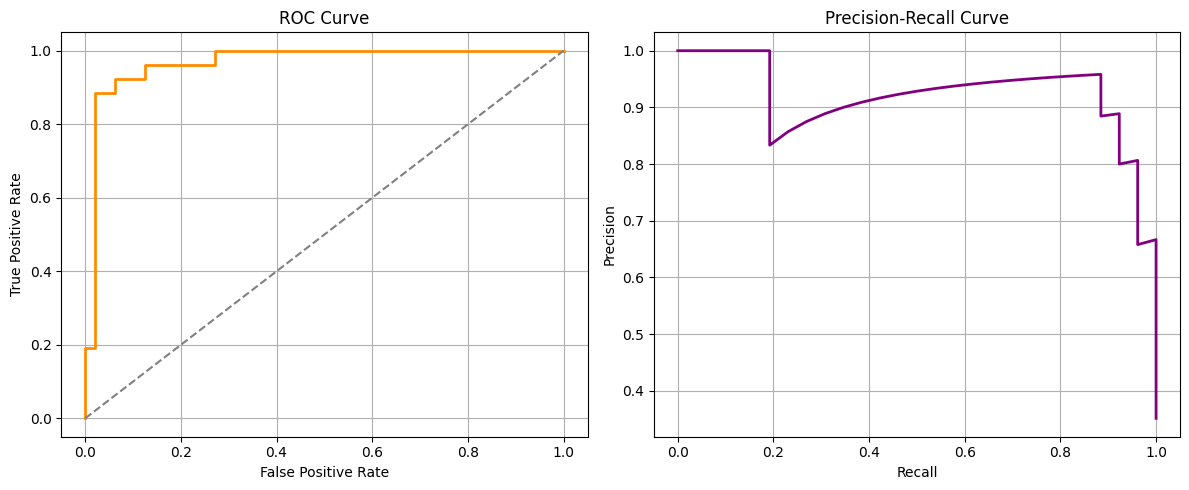

In [ ]:
from torchmetrics.classification import BinaryROC, BinaryPrecisionRecallCurve
import matplotlib.pyplot as plt
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = outputs[:, 1]

        all_probs.append(probs.cpu())
        all_preds.append(torch.argmax(outputs, dim=1).cpu())
        all_labels.append(labels.cpu())

all_probs = torch.cat(all_probs)
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

roc = BinaryROC()
fpr, tpr, thresholds_roc = roc(all_probs, all_labels)

pr_curve = BinaryPrecisionRecallCurve()
precision, recall, thresholds_pr = pr_curve(all_probs, all_labels)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

plt.tight_layout()
plt.show()
